In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from viz import plot_opinions_over_time, plot_campaign_budgets_with_order
from algos import compute_expected_value_for_budget_distribution, dynamic_programming_with_grid, forward_propagation_with_grid  
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from algos import *

In [4]:
def create_adjacency_matrix_from_links(num_nodes, links):
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for link in links:
        from_node, to_node = link
        # adjacency_matrix[from_node, to_node] = 1
        adjacency_matrix[to_node, from_node] = 1

    return adjacency_matrix

def init_env(): 
    links = [
        (1, 3),
        (3, 2),
        
        (2, 3),
        (2, 0),
        (0, 2),
        
        (1, 2),
        (0, 1),
        
    ]

    num_nodes = 4
    connectivity_matrix = create_adjacency_matrix_from_links(num_nodes, links)
    # connectivity_matrix = normalize_adjacency_matrix(connectivity_matrix)

    initial_opinions = np.linspace(0.7, 0, num_nodes)
    # initial_opinions = np.linspace(0, 1, num_nodes)
    # initial_opinions = (np.mod(np.arange(0, 0.1 * num_nodes, 0.1), 0.9)) + 0.1

    env = NetworkGraph(
        connectivity_matrix=connectivity_matrix,
        initial_opinions=initial_opinions,
        max_u=0.2,
        budget=100.0,
        desired_opinion=1.0,
        tau=0.5,
        max_steps=1_000_000,
    )

    env.reset()

    return env

[0.7        0.46666667 0.23333333 0.        ]


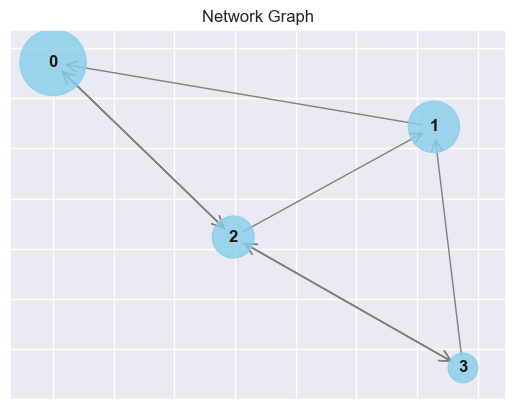

In [5]:
env = init_env()
print(env.opinions)
env.render(mode="matplotlib")

c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\rl_envs_forge\envs\network_graph\visualize.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_labels, y=sorted_centralities, palette="Blues_d")


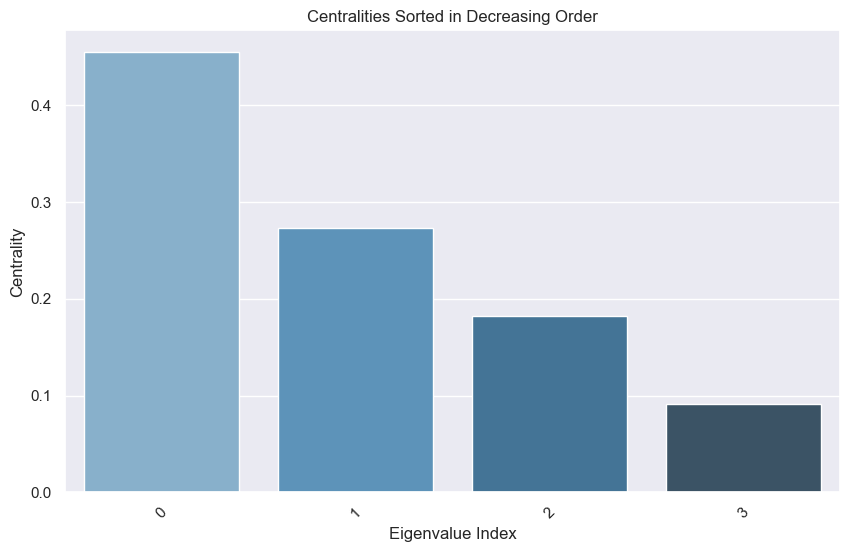

In [6]:
env.render(mode="centralities")

## Zero control 

Overall Error: 0.5204647904080085
Final Error: 0.5120701748735514


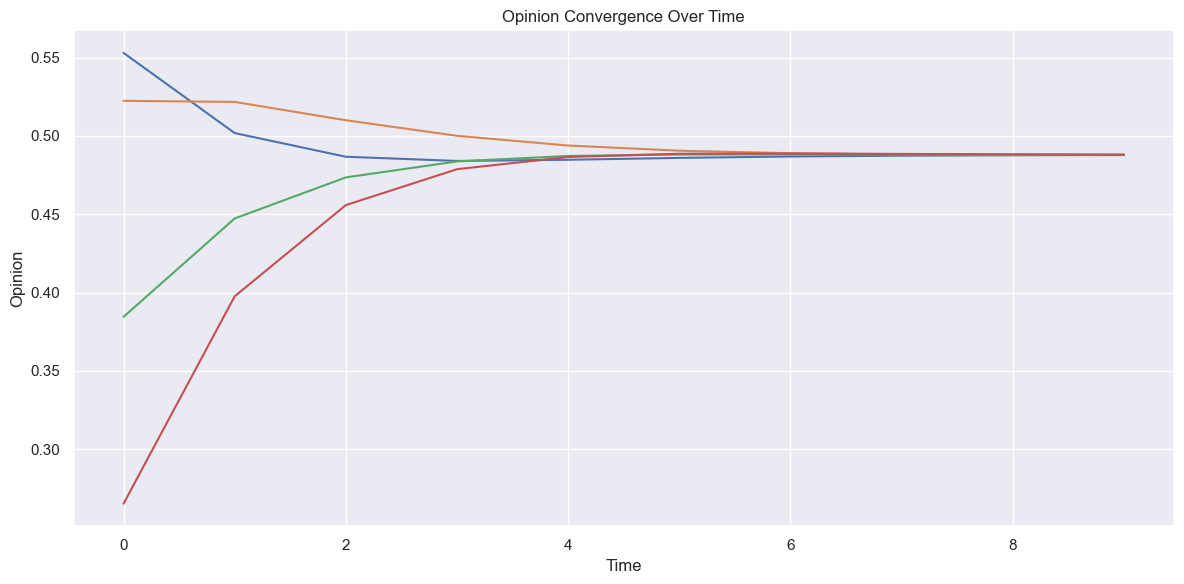

In [7]:
# Define the number of steps for which to apply the zero control input
env = init_env()

num_steps = 10

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    no_action_u = np.zeros(env.num_agents)  # Zero control input
    opinions, reward, done, truncated, info = env.step(no_action_u)
    opinions_over_time[i] = opinions


overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

### Infinite horizon

In [ ]:
import numpy as np
from itertools import product
from scipy.linalg import expm
from copy import deepcopy

def create_state_grid(N, nx):
    """Create a grid of states in the space [0, 1]^N."""
    grid_range = np.linspace(0, 1, nx)
    grids = [grid_range for _ in range(N)]
    return grids

def initialize_value_function(N, nx):
    """Initialize the value function as a zero vector."""
    grid_shape = tuple([nx] * N)
    return np.zeros(grid_shape)

def compute_dynamics(x, u, env):
    """Compute the next state given current state x and control u."""
    # Desired opinion
    d = env.desired_opinion
    step_duration = env.tau
    
    # Apply control to compute x_c
    x_c = u * d + (1 - u) * x
    
    # State transition using the matrix exponential of the Laplacian
    expL_remaining = expm(-env.L * step_duration)
    x_next = expL_remaining @ x_c
    return np.clip(x_next, 0, 1)

def reward_function(x, u, d, beta):
    """Compute the reward function."""
    return -np.abs(d - x).sum() - beta * np.sum(u)

def value_iteration(env, nx=10, gamma=0.9, beta=0.1, max_iterations=1000, tol=1e-6):
    """Perform value iteration to find the optimal policy."""
    N = env.num_agents
    ubar = env.max_u
    d = env.desired_opinion
    
    # Create state grid
    grids = create_state_grid(N, nx)
    grid_shape = tuple(len(grid) for grid in grids)
    
    # Initialize value function
    V = initialize_value_function(N, nx)
    
    # Discretize control actions (binary: either 0 or ubar for each agent)
    control_actions = list(product([0, ubar], repeat=N))
    
    # Value iteration
    for iteration in range(max_iterations):
        V_new = np.zeros_like(V)
        max_diff = 0
        
        # Loop over each state in the grid
        for idx in np.ndindex(grid_shape):
            current_state = np.array([grids[i][idx[i]] for i in range(N)])
            best_value = -np.inf
            
            # Loop over all possible control actions
            for control in control_actions:
                control_input = np.array(control)
                
                # Compute next state
                next_state = compute_dynamics(current_state, control_input, env)
                
                # Interpolate the value of the next state using nearest neighbor
                next_idx = tuple(np.abs(grids[i] - next_state[i]).argmin() for i in range(N))
                future_value = V[next_idx]
                
                # Compute reward
                immediate_reward = reward_function(current_state, control_input, d, beta)
                
                # Bellman update
                total_value = immediate_reward + gamma * future_value
                best_value = max(best_value, total_value)
            
            # Update value function at current state
            V_new[idx] = best_value
            max_diff = max(max_diff, abs(V_new[idx] - V[idx]))
        
        # Check for convergence
        if max_diff < tol:
            print(f"Converged in {iteration + 1} iterations.")
            break
        
        V = V_new
    
    return V

def extract_policy(env, V, nx=10, gamma=0.9, beta=0.1):
    """Extract the optimal policy from the value function."""
    N = env.num_agents
    ubar = env.max_u
    d = env.desired_opinion
    
    grids = create_state_grid(N, nx)
    grid_shape = tuple(len(grid) for grid in grids)
    
    control_actions = list(product([0, ubar], repeat=N))
    policy = {}
    
    for idx in np.ndindex(grid_shape):
        current_state = np.array([grids[i][idx[i]] for i in range(N)])
        best_value = -np.inf
        best_action = None
        
        for control in control_actions:
            control_input = np.array(control)
            next_state = compute_dynamics(current_state, control_input, env)
            
            next_idx = tuple(np.abs(grids[i] - next_state[i]).argmin() for i in range(N))
            future_value = V[next_idx]
            
            immediate_reward = reward_function(current_state, control_input, d, beta)
            total_value = immediate_reward + gamma * future_value
            
            if total_value > best_value:
                best_value = total_value
                best_action = control_input
        
        policy[idx] = best_action
    
    return policy

# Example usage
env = init_env()  # Assume env is already initialized with the necessary attributes
nx = 10  # Number of grid points per dimension
gamma = 0.9
beta = 0.1

# Perform value iteration to get the optimal value function
V = value_iteration(env, nx=nx, gamma=gamma, beta=beta)

# Extract the optimal policy based on the value function
policy = extract_policy(env, V, nx=nx, gamma=gamma, beta=beta)

print("\nOptimal Policy:")
for state_idx, action in policy.items():
    print(f"State {state_idx}: Control {action}")


In [ ]:
raise NotImplementedError

Dynamic Programming Strategy - Overall Error: 0.42578485812860584
Final Error: 0.3889476629653289
[array([1, 2], dtype=int64), array([0, 1], dtype=int64)]


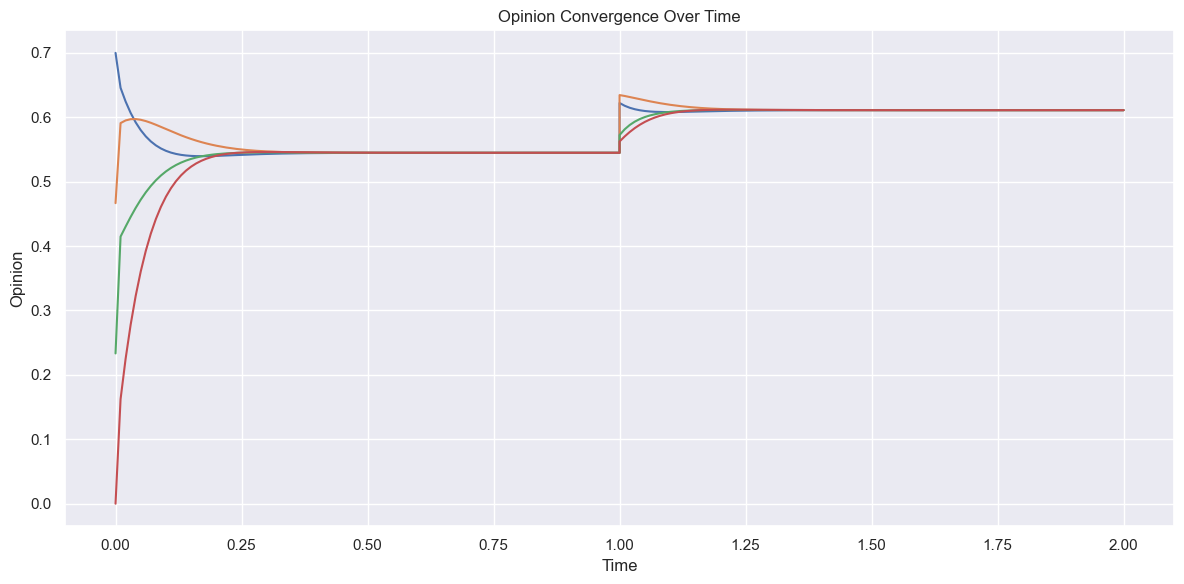

In [ ]:
from algos import normalize_campaign_time, run_dynamic_programming_campaigns

env = init_env()

step_duration = 10
sampling_time = 0.1
final_campaign_step_duration = 10  # Longer duration for the final campaign
final_campaign_sampling_time = sampling_time

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        BETA,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

### Fine DP

Dynamic Programming Strategy - Overall Error: 0.42578485812860584
Final Error: 0.3889476629653289
[array([1, 2], dtype=int64), array([0, 1], dtype=int64)]


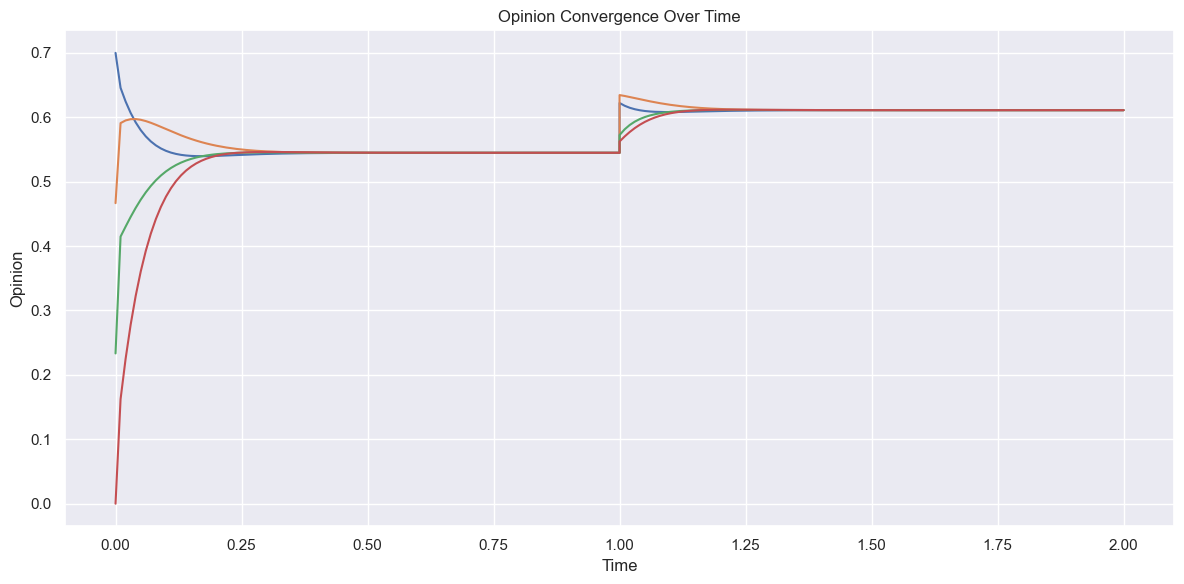

In [ ]:
from algos import normalize_campaign_time, run_dynamic_programming_campaigns

env = init_env()

step_duration = 10
sampling_time = 0.1
final_campaign_step_duration = 10  # Longer duration for the final campaign
final_campaign_sampling_time = sampling_time

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        BETA_hd,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

In [ ]:
### Brute force search

from itertools import product
from algos import run_dynamic_programming_campaigns, compute_average_error, compute_final_average_error
from viz import plot_opinions_over_time
from tqdm import tqdm

# Define parameters
total_budget = 4
num_campaigns = 2  # Number of campaigns
step_duration = 10
final_campaign_step_duration = 10  # Longer duration for the final campaign
sampling_time = 0.1
final_campaign_sampling_time = 0.1

# Initialize environment
env = init_env()

# Function to generate all valid budget allocations
def generate_valid_budget_allocations(total_budget, num_campaigns):
    """Generate all budget combinations where the sum of budgets is <= total_budget."""
    allocations = []
    for allocation in product(range(total_budget + 1), repeat=num_campaigns):
        if sum(allocation) <= total_budget:
            allocations.append(allocation)
    return allocations

# Get all valid budget allocations
valid_budget_allocations = generate_valid_budget_allocations(total_budget, num_campaigns)

# Store all results: budget combination and corresponding final error
results = []

# Brute-force search over all budget allocations
for budget_allocation in tqdm(valid_budget_allocations, desc="Running Campaigns"):
    # Reset environment for each test
    env = init_env()

    # Run the campaigns using the current budget allocation
    opinions_over_time, time_points, nodes_controlled_simulation = run_dynamic_programming_campaigns(
        env,
        budget_allocation,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )

    # Compute final error
    final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

    # Store the result as a tuple of (budget_allocation, final_error)
    results.append((budget_allocation, final_error))

# Sort results by final error (ascending)
results_sorted_by_error = sorted(results, key=lambda x: x[1])

# Function to display top N budget combinations
def show_top_n_budget_combinations(results_sorted, top_n=5):
    print(f"Top {top_n} Budget Combinations by Final Error:")
    for i in range(min(top_n, len(results_sorted))):
        budget_allocation, final_error = results_sorted[i]
        print(f"Rank {i+1}: Budget: {budget_allocation}, Final Error: {final_error}")

# Display the top N budget combinations
show_top_n_budget_combinations(results_sorted_by_error, top_n=5)

Running Campaigns: 100%|██████████| 15/15 [00:00<00:00, 65.97it/s]

Top 5 Budget Combinations by Final Error:
Rank 1: Budget: (2, 2), Final Error: 0.3889476629653289
Rank 2: Budget: (3, 1), Final Error: 0.38898072042628284
Rank 3: Budget: (1, 3), Final Error: 0.3952066147903484
Rank 4: Budget: (0, 4), Final Error: 0.4096969696969753
Rank 5: Budget: (4, 0), Final Error: 0.4096969696969758


In [ ]:
# results_sorted_by_error